In [ ]:
import cv2
import os
import sklearn
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import keras
from sklearn.preprocessing import LabelEncoder
import pandas as pd


In [ ]:
path_train = "/content/drive/MyDrive/Brain/Training"
path_test = "/content/drive/MyDrive/Brain/Testing"

In [ ]:
data = []
y = []

# loop through the directories and files in the training data path
for r, d, f in os.walk(path_train):
    for file in f:
        if '.jpg' in file:
            # if the file is an image file, append its path to the paths_train list
            path = os.path.join(r, file)
            # use the parent directory to determine the label for the image and append it to the y list
            if 'glioma_tumor' in r:
                y.append(3)
            elif 'meningioma_tumor' in r:
                y.append(2)
            elif 'pituitary_tumor' in r:
                y.append(1)
            elif 'no_tumor' in r:
                y.append(0)
            # load the image using PIL, resize it to 128x128, and append it to the data list
            img = Image.open(path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(np.array(img))

# loop through the directories and files in the testing data path
for r, d, f in os.walk(path_test):
    for file in f:
        if '.jpg' in file:
            # if the file is an image file, append its path to the paths_test list
            path = os.path.join(r, file)
            # use the parent directory to determine the label for the image and append it to the y list
            if 'glioma_tumor' in r:
                y.append(3)
            elif 'meningioma_tumor' in r:
                y.append(2)
            elif 'pituitary_tumor' in r:
                y.append(1)
            elif 'no_tumor' in r:
                y.append(0)
            # load the image using PIL, resize it to 128x128, and append it to the data list
            img = Image.open(path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(np.array(img))

In [ ]:
data = np.array(data)
y = np.array(y)
y = np_utils.to_categorical(y)
print(data.shape)
print(y.shape)

(3283, 128, 128, 3)
(3283, 4)


In [ ]:
data= data.astype('float32')
data/=255

AxesImage(size=(128, 128))


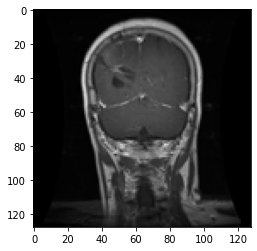

In [ ]:
print(plt.imshow(data[233]))

In [ ]:
X_train, X_test,y_train, y_test= train_test_split(data, y, test_size= 0.2 , shuffle = True, random_state = 42)

In [ ]:
aug = ImageDataGenerator(rotation_range=7,zoom_range=0.1,width_shift_range=0.05,
                        height_shift_range=0.05,horizontal_flip=True,
                        fill_mode="nearest")
TYPE = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
def modelXception():
    #Using the Xception Model
    input_shape = (128,128, 3)
    xception = Xception(weights="imagenet", input_shape=input_shape, include_top=False)

    # Adding the layers of Neural Network
    model = xception.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    model = tf.keras.layers.Dense(len(TYPE), activation="softmax")(model)
    model = tf.keras.models.Model(inputs=xception.input, outputs=model)

    # Compiling and fitting the model
    model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
    history = model.fit(aug.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test),
                        steps_per_epoch=len(X_train) // 32,epochs=15)

    # Plotting the training and validation accuracy and loss
    fig, ax = plt.subplots(1, 2)
    train_acc = history.history["accuracy"]
    train_loss = history.history["loss"]
    val_acc = history.history["val_accuracy"]
    val_loss = history.history["val_loss"]
    fig.set_size_inches(14, 7)

    ax[0].plot(range(len(train_acc)), train_acc, "go-", label="Training Accuracy")
    ax[0].plot(range(len(val_acc)), val_acc, "ro-", label="Validation Accuracy")
    ax[0].set_title("Training & Validation Accuracy")
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(range(len(train_loss)), train_loss, "g-o", label="Training Loss")
    ax[1].plot(range(len(val_loss)), val_loss, "r-o", label="Validation Loss")
    ax[1].set_title("Testing Accuracy & Loss")
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()


    # Evaluating Model
    result = model.evaluate(X_test, y_test)
    print("Testing Loss :", result[0])
    print("Testing Accuracy :", result[1]*100, "%")

    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis = 1)
    y_test_edit = np.argmax(y_test , axis = 1)

    cf_report = sklearn.metrics.classification_report(y_test_edit, predictions)
    print(cf_report)


In [ ]:


def modelEfficientNet():



    #load EfficientNet
    EfficientNet=EfficientNetV2S(weights='imagenet', include_top=False,input_shape=(128,128,3))
    tf.random.set_seed(45)
    model = EfficientNet.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model)
    model = tf.keras.layers.Dropout(rate=0.3)(model)
    model = tf.keras.layers.Dense(4,activation='softmax')(model)
    model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)
    opt = Adam(learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,epsilon=1e-08)

    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # # summarize the model
    # print(model.summary())

    # fit the model
    early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)
    history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=100, batch_size=13,callbacks=early_stopping_cb)

    #plot loss and accuracy
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    #plt.grid(True)

    #plt.gca().set_xlim(0,33)
    plt.gca().set_ylim(0,1)
    plt.savefig('/kaggle/working/EfficientNetB3.png')
    plt.grid()
    plt.title('Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('MOP')
    loss, accuracy = model.evaluate(X_test,y_test)

    #print accuracy
    print('Accuracy: %f' % (accuracy*100))

    loss, accuracy = model.evaluate(X_test,y_test)

83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/15
73/73 [==============================] - 569s 7s/step - loss: 0.6027 - accuracy: 0.7906 - val_loss: 1.4093 - val_accuracy: 0.6920
Epoch 2/15
73/73 [==============================] - 494s 7s/step - loss: 0.3113 - accuracy: 0.8902 - val_loss: 0.6449 - val_accuracy: 0.8555
Epoch 3/15
73/73 [==============================] - 505s 7s/step - loss: 0.2513 - accuracy: 0.9138 - val_loss: 0.7972 - val_accuracy: 0.8365
Epoch 4/15
73/73 [==============================] - 507s 7s/step - loss: 0.1990 - accuracy: 0.9318 - val_loss: 1.5696 - val_accuracy: 0.7262
Epoch 5/15
73/73 [==============================] - 493s 7s/step - loss: 0.1722 - accuracy: 0.9399 - val_loss: 0.2619 - val_accuracy: 0.9240
Epoch 6/15
73/73 [==============================] - 495s 7s/step - loss: 0.1504 - accuracy: 0.9468 - val_loss: 0.3820 - val_accuracy: 0.8935
Epoch 7/15
73/73 [==============================] - 508s 7s/step - loss: 0.1258 - accurac

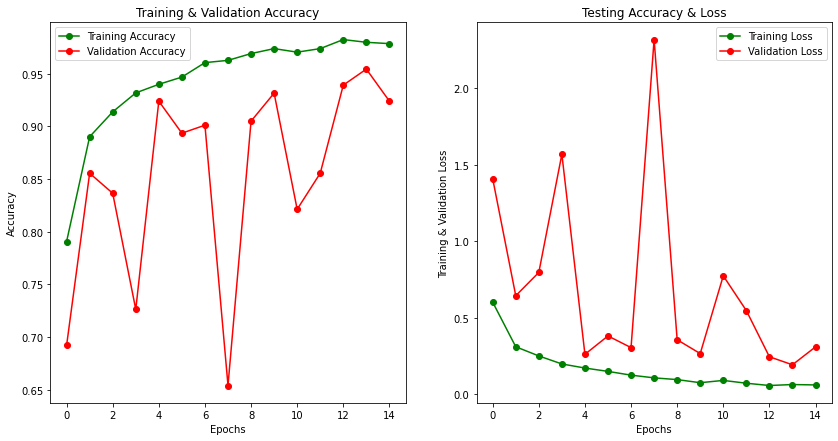

9/9 [==============================] - 12s 1s/step - loss: 0.3106 - accuracy: 0.9240
Testing Loss : 0.3105836510658264
Testing Accuracy : 92.39543676376343 %
9/9 [==============================] - 13s 1s/step
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        41
           1       0.93      0.96      0.95        73
           2       0.89      0.92      0.90        77
           3       0.98      0.85      0.91        72

    accuracy                           0.92       263
   macro avg       0.92      0.93      0.93       263
weighted avg       0.93      0.92      0.92       263



In [ ]:
if __name__ == '__main__':
    modelXception()
    #modelEfficientNet()

In [ ]:
X_test.shape

(263, 128, 128, 3)

In [ ]:
X_train.shape

(2363, 128, 128, 3)